<a href="https://colab.research.google.com/github/yu8867/SRS/blob/main/SRS_steady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.stats import norm
import math
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
from scipy.special import beta
from decimal import *

In [ ]:
class Agent:
  def __init__(self, E, arm_times, arm_random_p, arm_size):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.arm_size = arm_size
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)

  def updata(self, reward, action):
    self.arm_times[action] += 1

    #報酬
    a = 1/(self.arm_times[action])
    self.E[action] = (1-a) * self.E[action] + a * reward

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0    


class Agent_TS:
  def __init__(self, E, arm_times, arm_random_p, arm_size):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.success = np.zeros(len(E))
    self.fail = np.zeros(len(E))
    self.arm_size = arm_size
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)
    self.success = np.zeros(self.arm_size)
    self.fail = np.zeros(self.arm_size)

  def updata(self, reward, action):
    self.arm_times[action] += 1
    #報酬
    self.E = ((self.arm_times[action]-1)/self.arm_times[action])*self.E + (1/self.arm_times[action]) * reward
    if reward == 1:
      self.success[action] = self.success[action] +1
    elif reward == 0:
      self.fail[action] = self.fail[action] + 1

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0    

#方策

In [ ]:
######################################
class SRS:
  def __init__(self, p, epsilon):
    self.aleph = p.max()
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon
    # b = (N * row - arm_times)/row

    SRS = (N + b.max()) * row - arm_times
    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class SRS_CH:
  def __init__(self, p, epsilon):
    self.aleph = 1.0
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    Dkl = E * np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu_ch = np.exp((-1)*arm_times*Dkl)
    aleph = np.nan_to_num(E_max*((1-(E/E_max)*myu_ch)/(1-myu_ch)),nan=0)
    max_aleph = aleph.max()

    if  E.max() > max_aleph:
      E = E - E.max() + max_aleph - self.epsilon  

    Z = 1/(np.sum(1/(max_aleph - E)))
    row = Z / (max_aleph - E)
    b = (arm_times / row) - N + self.epsilon
    SRS = (N + b.max()) * row - arm_times

    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class SRS_OPT:
  def __init__(self, p, epsilon):
    p = sorted(p,reverse=True)
    self.aleph = (p[0] + p[1])/2
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times

    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

# getcontext().prec = 8
# Decimal(1234567654321)
######################################
class RS:
  def __init__(self, p, epsilon):
    self.aleph = p.max()
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / N)*(E - self.aleph)
    
    return np.argmax(RS)

######################################
class RS_CH:
  def __init__(self, p, epsilon):
    self.epsilon = epsilon
  
  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    Dkl = E * np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu_ch = np.exp((-1)*arm_times*Dkl)
    aleph = np.nan_to_num(E_max*((1-(E/E_max)*myu_ch)/(1-myu_ch)),nan=0)
    max_aleph = aleph.max()

    RS = arm_times*(E - max_aleph)/N
    greedy = np.argmax(E)
    
    A = np.where(RS[greedy] <= RS)[0]
    if len(A)>=2:
      max_myu = max(myu_ch[A])
      B = np.where(myu_ch == max_myu)[0]
      if len(B) == 1:
        a = B[0]
      else:
        max_aleph = max(aleph[B])
        C = np.where(aleph == max_aleph)[0]
        a = np.random.choice(C)
    else:
      a = greedy
    
    return a

######################################
class RS_OPT:
  def __init__(self, p, epsilon):
    p = sorted(p,reverse=True)
    self.aleph = (p[0] + p[1])/2
  
  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / N)*(E - self.aleph)
    
    return np.argmax(RS)

######################################
class TS:
  def __init__(self, p, epsilon):
    self.p = p
  
  def select_arm(self, E, arm_times, N, agent):
    myu = np.array([np.random.beta(agent.success[action]+1, agent.fail[action]+1) for action in range(agent.arm_size)])
    return np.argmax(myu)

In [ ]:
class Simulater:
  def __init__(self, n_sim, steps, arm_size, epsilon):
    self.steps = steps
    self.n_sim = n_sim
    self.arm_size = arm_size
    self.epsilon = epsilon
  
  def test(self, policy, Agent):
    agent = Agent(np.array([0.5]*self.arm_size), np.array([10**-7]*self.arm_size), np.zeros(self.arm_size), self.arm_size)
    regret = np.zeros((self.n_sim, self.steps))

    for sim in tqdm(range(self.n_sim)):
      p = agent.random_prob(self.arm_size)
      pi = policy(p, self.epsilon)

      for step in range(0, self.steps):
        action = pi.select_arm(agent.E, agent.arm_times, step+1, agent)
        reward = agent.reward(p,action)
        agent.updata(reward, action)
        regret[sim, step] += regret[sim, step-1] + np.max(p) - p[action]
      agent.initialize()
    return regret

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


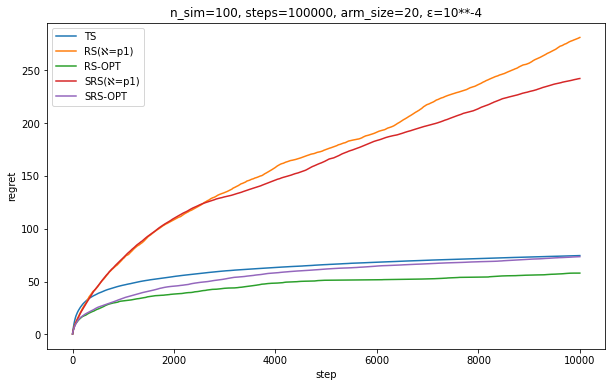

In [ ]:
simulata = Simulater(n_sim=100, steps=10000, arm_size=20, epsilon=10**-4)
regret_TS = simulata.test(TS, Agent_TS)
regret_SRS = simulata.test(SRS, Agent)
regret_SRS_OPT = simulata.test(SRS_OPT, Agent)
regret_RS = simulata.test(RS, Agent)
regret_RS_OPT = simulata.test(RS_OPT, Agent)


plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
plt.plot(np.mean(regret_TS, axis=0), label="TS")
plt.plot(np.mean(regret_RS, axis=0), label="RS(ℵ=p1)")
plt.plot(np.mean(regret_RS_OPT, axis=0), label="RS-OPT")
plt.plot(np.mean(regret_SRS, axis=0), label="SRS(ℵ=p1)")
plt.plot(np.mean(regret_SRS_OPT, axis=0), label="SRS-OPT")
plt.title("n_sim=100, steps=100000, arm_size=20, ε=10**-4")
plt.legend()
plt.show()